In [6]:
import pandas as pd
import numpy as np
import csv
from tqdm import tqdm
import torch

In [7]:
# select cpu
torch.cuda.is_available = lambda : False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)
if device.type == "cuba":
    print(torch.cuba.get_device_name(0))
    
# version
print(f"Torch version: {torch.__version__}")

Using device:  cpu
Torch version: 1.12.1+cu102


In [9]:
# data
def get_smiles_solibity(filename):
    
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        next(reader)
        
        smiles = []
        sol = []
        for row in reader:
            smiles.append(row[3])
            sol.append(float(row[4]))
        return smiles, sol

In [10]:
# molecular fingerprints calc
from rdkit import Chem
from rdkit.Chem import AllChem

def fingerprints(smiles, radius=2, nbits=2048):
    fps = []
    mols = [Chem.MolFromSmiles(x) for x in smiles]
    for m in mols:
        fp = np.array(AllChem.GetMorganFingerprintAsBitVect(m, radius=radius, nBits=nbits))
        fps.append(fp)
    return fps

In [11]:
data = get_smiles_solibity('../../data/AqSolDB_v1.0_min.csv')

In [12]:
fprints = fingerprints(data[0])

[22:50:36] WARNING: not removing hydrogen atom without neighbors
[22:50:36] WARNING: not removing hydrogen atom without neighbors
[22:50:36] WARNING: not removing hydrogen atom without neighbors
[22:50:36] WARNING: not removing hydrogen atom without neighbors
[22:50:36] WARNING: not removing hydrogen atom without neighbors
[22:50:36] WARNING: not removing hydrogen atom without neighbors
[22:50:36] WARNING: not removing hydrogen atom without neighbors
[22:50:36] WARNING: not removing hydrogen atom without neighbors
[22:50:36] WARNING: not removing hydrogen atom without neighbors
[22:50:36] WARNING: not removing hydrogen atom without neighbors
[22:50:36] WARNING: not removing hydrogen atom without neighbors
[22:50:36] WARNING: not removing hydrogen atom without neighbors
[22:50:36] WARNING: not removing hydrogen atom without neighbors
[22:50:36] WARNING: not removing hydrogen atom without neighbors
[22:50:36] WARNING: not removing hydrogen atom without neighbors
[22:50:36] WARNING: not r

In [59]:
# features
X = np.array(fprints)
y = np.array(data[1])

In [60]:
# data split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.25) 

In [61]:
# standardize features
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)

In [62]:
# Create tensors from arrays
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train).float()

In [37]:
# pytorch dataset
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(X_train_norm, y_train)

In [38]:
# dataloader
torch.manual_seed(1)
batch_size = 8
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [39]:
# parameters
input_size = X_train_norm.shape[1]
hidden_size = 100
output_size = 3

In [40]:
# model bulding
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size),
)

In [41]:
model

Sequential(
  (0): Linear(in_features=2048, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=3, bias=True)
)

In [42]:
# loss function
loss_fn = nn.MSELoss()

In [43]:
# optimization
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [47]:
# training the model
torch.manual_seed(1)
num_epochs = 200
log_epochs = 20

for epoch in range(num_epochs):
    loss_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:,0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train += loss.item()
    if epoch % log_epochs ==0:
        print(f"Epoch {epoch} Loss "
              f"{loss_hist_train / len(train_dl):.4f}")

Epoch 0 Loss 0.1460
Epoch 20 Loss 0.1094
Epoch 40 Loss 0.0987
Epoch 60 Loss 0.0891
Epoch 80 Loss 0.0875
Epoch 100 Loss 0.0825
Epoch 120 Loss 0.0819
Epoch 140 Loss 0.0790
Epoch 160 Loss 0.0779
Epoch 180 Loss 0.0775


In [63]:
# model evaluation of test dataset
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test).float()

with torch.no_grad():
    pred_test = model(X_test_norm)[:,0]
    pred_train = model(X_train_norm)[:,0] ## for plotting
    loss = loss_fn(pred_test, y_test)
    print(f"Test MSE: {(loss.item()):.4f}")
    print(f"Test MAE: {nn.L1Loss()(pred_test, y_test).item():.4f}")

Test MSE: 1.7611
Test MAE: 0.9486


In [ ]:
import matplotlib.pyplot as plt
plt.rcdefaults()

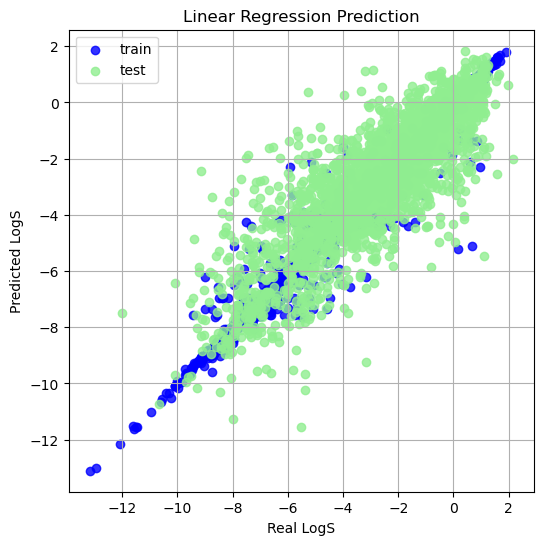

In [64]:
plt.title("Linear Regression Prediction")
plt.xlabel("Real LogS")
plt.ylabel("Predicted LogS")
plt.grid()
plt.rcParams["figure.figsize"] = [6,6]

plt.scatter(y_train, pred_train, 
            color="blue", alpha=0.8, label="train")
plt.scatter(y_test, pred_test, 
            color="lightgreen", alpha=0.8, label="test")

plt.legend(loc = 'best')
plt.show()